In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [15]:
df = pd.read_csv('timed_cylces_1000_delay_0.csv')

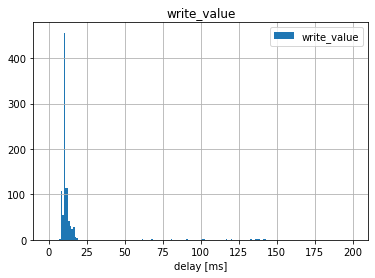

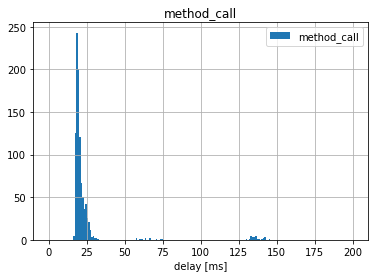

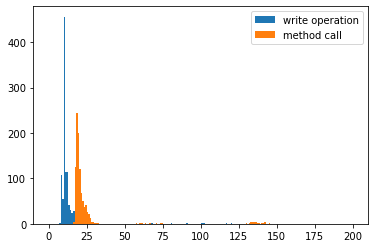

In [31]:
df_ms = df*10**-6
bins = np.linspace(0,200, 200)
df_ms.hist(column=['write_value'], bins=bins, legend=True)
plt.xlabel('delay [ms]')
df_ms.hist(column=['method_call'], bins=bins, legend=True)
plt.xlabel('delay [ms]')
plt.show()

plt.hist(df_ms['write_value'], bins=bins, label='write operation')
plt.hist(df_ms['method_call'], bins=bins, label='method call')
plt.legend()
plt.show()